# QED-C Application-Oriented Benchmarks - Modularized Qiskit Version
The notebook demonstrates problem generation, execution, and analysis of one of the many supported application-oriented benchmarks for the Qiskit API in a modularized fashion.   

Configure and run the cell below with the desired execution settings, then proceed to run the remaining cells.

In [1]:
min_qubits=2
max_qubits=8
skip_qubits=1
max_circuits=3
num_shots=1000

## Part 1: Problem Generation

Utilizing the new **_get_circuits_** flag in the architecture, we can supress execution and obtain only the problem generation components of interest.

The code below grabs the Bernstein-Vazirani Method 1 circuits and any metadata associated with them.

In [2]:
from bernstein_vazirani import bv_benchmark

circuits, metadata = bv_benchmark.run(
    min_qubits=min_qubits, max_qubits=max_qubits, skip_qubits=skip_qubits,
    max_circuits=max_circuits, num_shots=num_shots, method=1, get_circuits=True
)

print(f"\nCircuits:\n{circuits}")
print(f"\nMetadata: \n{metadata}")

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Feb 04, 2026 06:14:44 UTC
************
Creating [3] circuits with num_qubits = 3
************
Creating [3] circuits with num_qubits = 4
************
Creating [3] circuits with num_qubits = 5
************
Creating [3] circuits with num_qubits = 6
************
Creating [3] circuits with num_qubits = 7
************
Creating [3] circuits with num_qubits = 8
************
Returning circuits and circuit information

Circuits:
{'3': {'1': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12CA350>, '2': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1298ED0>}, '4': {'1': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12B6ED0>, '3': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1263CD0>, '5': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1129590>}, '5': {'2': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C

### The Circuits and Metadata
Note the format of the outputs:
- **circuits**: dict[str, dict[str, QuantumCircuit]] 
- **metadata**: dict[str, dict[str, dict[str, float]] | str]

Where 
1. The **first dictionary's key** represents the **number of qubits** for the group. In _metadata_, it may also serve as the subtitle.
2. The **second dictionary's key** represents the **unique identifier** for a circuit in the group. This may be a secret string for Bernstein-Vazirani, theta value for Phase-Estimation, and so on. Benchmark specific documentation can be found in our repository.
3. The **third dictionary's key** represents the **metric being stored** in _metadata_. (There is no third dictionary in _circuits_).

## Part 2: Execution

Now that we have the Qiskit circuits, we are free to run them using any execution framework that supports Qiskit!

### Preprocessing and Additional Metrics
We first convert the _circuits_ dictionary into a flat list; additionally, we choose to compute additional metrics and store them in the metrics module.

In [3]:
from _common import metrics
from _common.qiskit import execute as ex

# Remove the subtitle key for iterating purposes.
metadata.pop("subtitle", None)

# Copy any metadata from creation (i.e. create_time). This can be excluded if it's not of interest.
metrics.circuit_metrics = metadata

# Create a flat list of circuits.
circuit_identifiers = []
flat_circuits = []
for num_qubits in circuits.keys():
    for circuit_id in circuits[num_qubits].keys():
        circuit_identifiers.append((num_qubits, circuit_id))
        flat_circuits.append(circuits[num_qubits][circuit_id])

        # Optionally compute additional circuit properties (depth, etc.) and store to metrics.
        ex.compute_and_store_circuit_info(
            circuits[num_qubits][circuit_id],
            str(num_qubits),
            str(circuit_id),
            do_transpile_metrics=True,
            use_normalized_depth=True,
        )

print(f"Flat Circuits: \n{flat_circuits}\n")
print(f"Additional Metrics: \n{metrics.circuit_metrics}")

Flat Circuits: 
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12CA350>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1298ED0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12B6ED0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1263CD0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC1129590>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12C1410>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C9E2F21110>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C9E2FABF90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001CAC12D3A10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C9E2F72910>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C9E2FBC710>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C9E2ECA9D0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0

## Running Circuits

We can choose to run on any execution platform that supports Qiskit circuits; for example, running through qBraid, _pyGSTi_, or a custom platform. 

For the sake of this demonstration, we will execute through a simple simulator.  

In [4]:
#TODO: Replace this with hardware. I was wondering if it's possible to use our Execution module instead.
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator

sim = Aer.get_backend("aer_simulator")
tqc = transpile(flat_circuits, sim)
result = sim.run(tqc, shots=num_shots).result()

In [5]:
print(result.get_counts())

[{'01': 1000}, {'10': 1000}, {'001': 1000}, {'011': 1000}, {'101': 1000}, {'0010': 1000}, {'0111': 1000}, {'1000': 1000}, {'00110': 1000}, {'01111': 1000}, {'10010': 1000}, {'001001': 1000}, {'001010': 1000}, {'001110': 1000}, {'1010001': 1000}, {'1110100': 1000}, {'1000110': 1000}]


## Part 3: Analysis and Results
After executing the circuits, we can use the counts to compute the fidelities, store them, and plot the results.

### Computing Fidelities
The code below uses the counts from above and stores them in the metrics module, which can then be used to create plots. 

In [6]:
from bernstein_vazirani import bv_benchmark

class CountsWrapper:
        """
        A wrapper class to enable support with QED-C's method to analyze results.
        """

        def __init__(self, counts: dict[str, int]):
            self.counts = counts

        def get_counts(self, _):
            return self.counts
            
# Iterate over each submitted circuit using the circuit identifiers:
for curr_idx, (num_qubits, circuit_id) in enumerate(circuit_identifiers):
    # Wrap the counts
    counts = result.get_counts(curr_idx)
    result_obj = CountsWrapper(counts)
    
    # Compute the fidelity
    _, fidelity = bv_benchmark.analyze_and_print_result(
        None, result_obj, int(num_qubits), num_shots, s_int=int(circuit_id), 
    )
    
    # Store the fidelity.
    metrics.store_metric(num_qubits, circuit_id, "fidelity", fidelity)

### Visualization

Now that the fidelities are stored, we can use the metrics module to create plots. 

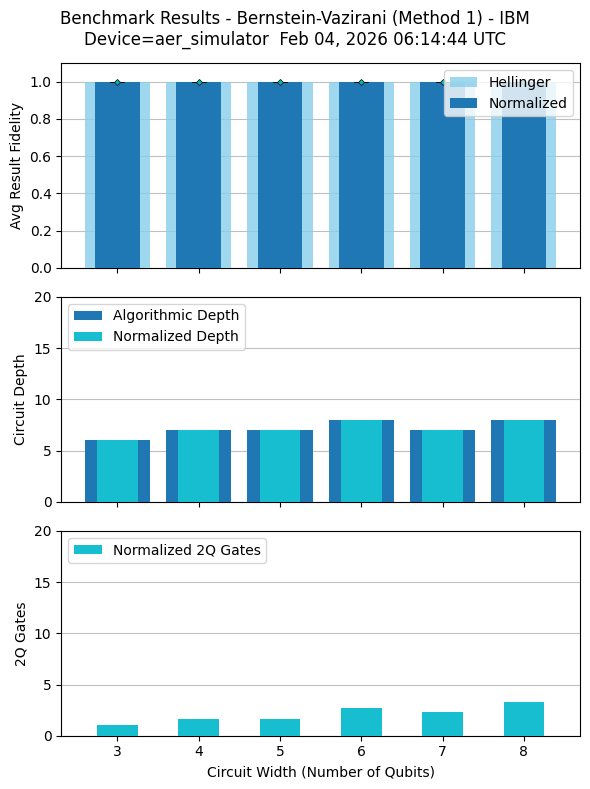

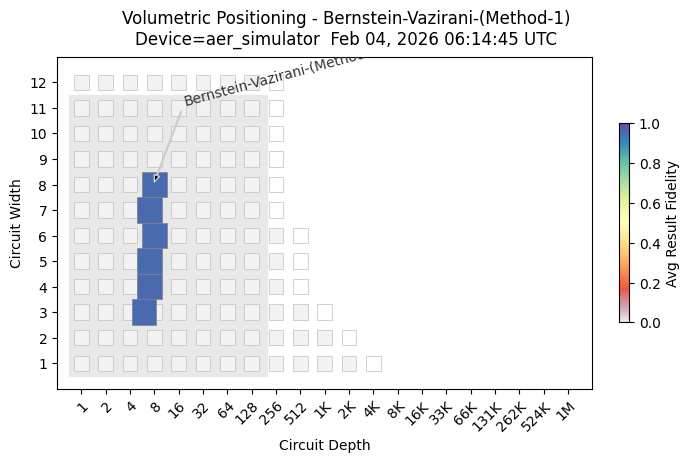

In [7]:
# Compute statistics for metrics.
metrics.aggregate_metrics()

# Set information for plot titles.
benchmark_name = "Bernstein-Vazirani"
provider_name = "IBM"
device_name = "aer_simulator"

# Set plot titles.
benchmark_title = f"{benchmark_name} (Method 1)"
subtitle = f"Benchmark Results - {benchmark_title} - {provider_name}"
metrics.circuit_metrics["subtitle"] = f"device = {device_name}"

# Determine which metrics to plot.
filters = ["fidelity", "hf_fidelity", "depth", "2q", "vbplot"]

# Plot the metrics.
metrics.plot_metrics(subtitle, filters=filters)